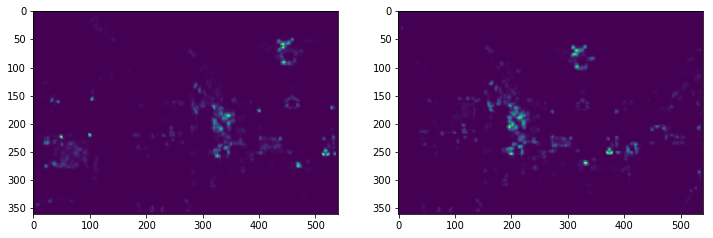

In [2]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
from utils import *

i2 = plt.imread('n1_small.jpg')
i1 = plt.imread('n2_small.jpg')
i1 = i1.mean(axis=2)
i2 = i2.mean(axis=2)
h1 = harris_response(i1)
h2 = harris_response(i2)
fig, axs = plt.subplots(ncols=2, figsize=(12, 8))
axs[0].imshow(h1)
axs[1].imshow(h2)
plt.show()

In [3]:
x1, y1 = local_max(h1)
x2, y2 = local_max(h2)
x1, y1 = adaptive_suppression(h1, y1, x1)
x2, y2 = adaptive_suppression(h2, y2, x2)

d1, out_x1, out_y1 = extract_descriptors(i1, x1, y1)
d2, out_x2, out_y2 = extract_descriptors(i2, x2, y2)

In [4]:
ix1, ix2 = match_descriptors(d1, d2, out_x1, out_y1, out_x2, out_y2)

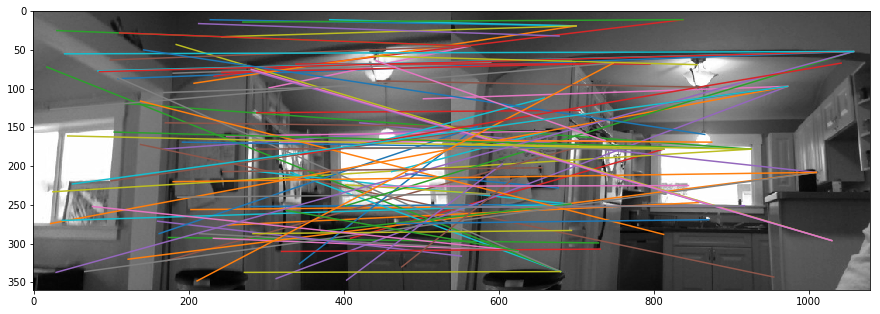

In [5]:
match_x1, match_y1 = unpack(ix1)
match_x2, match_y2 = unpack(ix2)
match_x2 += i1.shape[1]

out_im = np.concatenate((i1, i2), axis=1)
plt.figure(figsize=(15, 12))
plt.imshow(out_im, cmap='gray')
for x, y, xx, yy in zip(match_x1, match_y1, match_x2, match_y2):
    plt.plot([x, xx], [y, yy])
plt.show()

In [6]:
ix1, ix2 = match_descriptors_threshold(d1, d2, out_x1, out_y1, out_x2, out_y2)

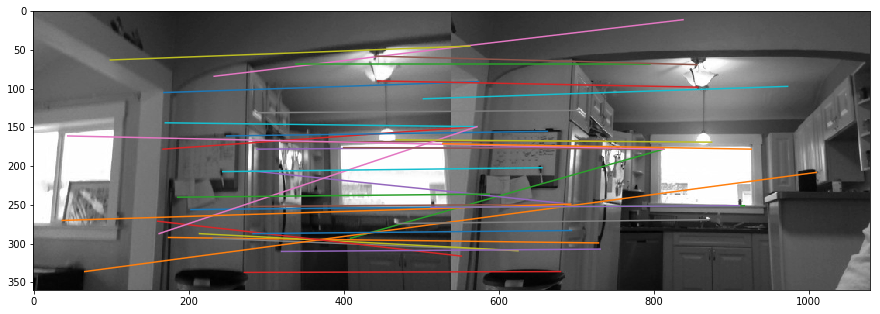

In [7]:
match_x1, match_y1 = unpack(ix1)
match_x2, match_y2 = unpack(ix2)
match_x2 += i1.shape[1]

out_im = np.concatenate((i1, i2), axis=1)
plt.figure(figsize=(15, 12))
plt.imshow(out_im, cmap='gray')
i = 0
for x, y, xx, yy in zip(match_x1, match_y1, match_x2, match_y2):
    plt.plot([x, xx], [y, yy])
    i+=1
plt.show()

In [8]:
match_x2 -= i1.shape[1]
pts1 = np.vstack((match_x1, match_y1)).T
pts2 = np.vstack((match_x2, match_y2)).T

H_test = homography(pts1, pts2)
print(H_test)


[ 1.80123051e-03  1.67147320e-03 -7.66959100e-01  1.25923676e-03
  1.71563852e-03 -6.41682063e-01  5.61022811e-06  6.55717139e-06
 -2.70205512e-03]


In [9]:
def RANSAC(n_iter, pts1, pts2, sample_size, min_inliers, r=5):
    ''' pts1: np.array with shape (n_matches, 2) '''
    H_best = None
    inliers = []
    for m in range(n_iter):
        indices = np.random.choice(pts1.shape[0], size=sample_size, replace=False)
        indices = sorted(indices)
        
        # split the lists into a sample and the complement
        samp1 = np.zeros(shape=(sample_size, 2))
        samp2 = np.zeros(shape=(sample_size, 2))
        n1 = np.zeros(shape=(pts1.shape[0]-sample_size, 2))
        n2 = np.zeros(shape=(pts2.shape[0]-sample_size, 2))
        j = 0
        k = 0
        for i in range(pts1.shape[0]):
            if i in indices:
                samp1[j] = pts1[i]
                samp2[j] = pts2[i]
                j += 1
            else:
                n1[k] = pts1[i]
                n2[k] = pts2[i]
                k += 1
        
        H_maybe = homography(samp1, samp2)
        H_maybe = np.reshape(H_maybe, (3, 3))
        
        n1_with_ones = np.hstack((n1, np.ones((n1.shape[0], 1))))
        
        Xprime = H_maybe @ n1_with_ones.T # predict n1's points based on H_maybe, compare to locations in n2.
        Xprime = Xprime.T
        Xprime = Xprime[:, :2] / Xprime[:, 2][:, np.newaxis]
        sub_inliers = []
        for pair1, pair2 in zip(Xprime, n2):
            #print(pair1, pair2)
            test_r = residual(pair1[0], pair2[0], pair1[1], pair2[1])
            
            #print('Residual:', test_r, '\n')

            if  test_r < r:
                #print(pair1, pair2)
                sub_inliers.append((pair1, pair2))
    
        if len(sub_inliers) > len(inliers) and len(sub_inliers) >= min_inliers:
            inliers = sub_inliers
            H_best = H_maybe
    return H_best, np.array(inliers)

In [20]:
n_iter = 1000
H_best, inliers = RANSAC(n_iter, pts1, pts2, 10, 3)

print('\n', H_best, '\n\n', inliers)


 [[-6.87059396e-03  2.77772134e-04  9.41519052e-01]
 [-1.03309981e-03 -6.03448057e-03  3.36797101e-01]
 [-3.65706181e-06  1.56666118e-07 -4.98233859e-03]] 

 [[[ 67.21683252 249.40106477]
  [ 67.         252.        ]]

 [[152.88650016 246.89130732]
  [153.         249.        ]]

 [[164.41748073 172.2582066 ]
  [164.         175.        ]]

 [[ 47.95527179 231.75926653]
  [ 48.         236.        ]]

 [[191.83413149 305.45119251]
  [191.         307.        ]]

 [[273.90821381 177.40481852]
  [273.         178.        ]]

 [[334.11266124 172.23237376]
  [335.         169.        ]]

 [[383.16477343 180.14664365]
  [386.         178.        ]]

 [[375.76937542 252.37642184]
  [377.         251.        ]]

 [[368.51478192 252.23104489]
  [371.         251.        ]]

 [[314.65183683  71.18108622]
  [316.          69.        ]]]


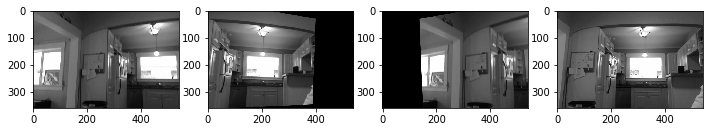

In [27]:
import skimage.transform as skt
# Create a projective transform based on the homography matrix $H$
proj_trans = skt.ProjectiveTransform(H_best)
proj_trans2 = skt.ProjectiveTransform(np.linalg.inv(H_best))

# Warp the image into image 1's coordinate system
im_trans = skt.warp(i2,proj_trans2)
im_trans2 = skt.warp(i1,proj_trans)

fig, axs = plt.subplots(ncols=4, figsize=(12, 8))
axs[0].imshow(i1, cmap='gray')
axs[1].imshow(im_trans, cmap='gray')
axs[2].imshow(im_trans2, cmap='gray')
axs[3].imshow(i2, cmap='gray')
plt.show()

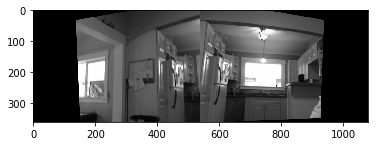

In [36]:
out = np.concatenate((im_trans2[:, :-100], im_trans), axis=1)
plt.imshow(out, cmap='gray')
plt.show()